This notebook is part of the SelfiSys project and is licensed under the GNU General Public License v3.0 or later (GPL-3.0-or-later). See the accompanying LICENSE file or visit [GNU GPL](https://www.gnu.org/licenses/gpl-3.0.en.html) for details.

Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Explore the forward model of galaxy surveys

Implement a hidden-box forward model of a spectroscopic galaxy survey.

## Set up the environment and parameters

In [1]:
from selfisys.global_parameters import *

In [2]:
wd_ext = "demo/"  # Extension for the output directory
name = "ref_n01"  # Name for this run
# Set simulation parameters. Examples:
#  - custom19COLA20: COLA, z_ini = 19, 20 time steps, non-linear RSDs
#  - custom19PM20: PM, z_ini = 19, 20 time steps, non-linear RSDs
#  - custom19COLA20lin: COLA, z_ini = 19, 20 time steps, linear RSDs
sim_params = "custom19COLA20"  # Simulation parameters
force = True  # Overwrite existing files?
force_obs = True  # Overwrite existing observations?
RSDs = True  # Use the redshift-space fields for the observations?
id_obs = "obs_rawmask_n01_wRSDs"  # Identifier for the observations
size = 128  # Grid size
Np0 = 128  # Number of dark matter particles per spatial dimension.
Npm0 = 128  # Side length of the particle-mesh grid in voxels.
L = 3600  # Side length of the simulation box in Mpc/h.
S = 64  # Number of support wavenumbers for the input power spectrum.
Pinit = 50  # Maximum number of bins for the summaries.
Nnorm = 2  # Number of simulations to compute the normalisation factor.
# Time stepping:
aa = [0.05, 0.55, 0.67, 0.8696]  # Initial and snapshot scale factors
total_steps = 10  # Total number of time steps for the gravity solver
# Path to the survey mask (optional):
survey_mask_path = OUTPUT_PATH + "expl_notebooks/surveymask/raw_mask_N128.npy"
# Radial selection parameters:
radial_selection = "multiple_lognormal"
selection_params = [
    0.1150,
    0.1492,
    0.1818,
    0.1500,
    0.4925,
    0.8182,
    1,
    1,
    1,
]
lin_bias = [1.47, 1.99, 2.32]  # Linear galaxy biases
obs_density = None  # Observed galaxy density
noise = 0.1  # Noise level

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import exists
from pathlib import Path

from pysbmy.timestepping import *
from selfisys.setup_model import *
from selfisys.hiddenbox import HiddenBox
from selfisys.utils.tools import get_k_max
from selfisys.utils.timestepping import merge_nTS
from selfisys.utils.plot_utils import *
from selfisys.utils.plot_examples import plot_galaxy_field_slice
from selfisys.utils.examples_utils import clear_large_plot

seedphase = BASELINE_SEEDPHASE
seednoise = BASELINE_SEEDNOISE
seednorm = BASELINE_SEEDNORM
seedphase_obs = SEEDPHASE_OBS
seednoise_obs = SEEDNOISE_OBS
baseid_obs = BASEID_OBS  # Warning: never prepend a prefix to BASEID_OBS

# Configure plotting aesthetics for consistent visualisation
setup_plotting()

In [4]:
k_max = get_k_max(L, size)  # k_max in h/Mpc
print(f"k_max = {k_max}")
Npop = len(lin_bias) if not isinstance(lin_bias, float) else 1
gravity_on = sim_params[:6] != "nograv"
# Cosmo at the expansion point:
params_planck = params_planck_kmax_missing.copy()
params_planck["k_max"] = k_max
# Cosmo for BBKS spectrum with fiducial cosmology (for normalisation):
params_BBKS = params_BBKS_kmax_missing.copy()
params_BBKS["k_max"] = k_max
# Groundtruth cosmology:
params_cosmo_obs = params_cosmo_obs_kmax_missing.copy()
params_cosmo_obs["k_max"] = k_max

if radial_selection == "multiple_lognormal":
    selection_params = np.reshape(np.array(selection_params), (3, -1))

# Create output directories:
wd = f"{OUTPUT_PATH}{wd_ext}{size}{int(L)}{Pinit}{Nnorm}/{name}/"
modeldir = wd + "model/"

Path(modeldir).mkdir(parents=True, exist_ok=True)
Path(wd, "data").mkdir(parents=True, exist_ok=True)
Path(wd, "Figures").mkdir(exist_ok=True)

k_max = 0.194


In [5]:
params = setup_model(
    workdir=modeldir,
    params_planck=params_planck,
    params_P0=params_BBKS,
    size=size,
    L=L,
    S=S,
    Pinit=Pinit,
    force=force,
)
(
    size,
    L,
    P,
    S,
    G_sim_path,
    G_ss_path,
    Pbins_bnd,
    Pbins,
    k_s,
    P_ss_obj_path,
    P_0,
    planck_Pk_EH,
) = params


def theta2P(theta):
    return theta * P_0

[21:58:51|INFO      ]|(selfisys.setup_model) Computing Fourier grid...
[21:58:51|STATUS    ]|Setting up Fourier grid...
[21:58:51|STATUS    ]|Setting up Fourier grid done.
[21:58:51|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/G_sim.h5'...
[21:58:51|DIAGNOSTIC]==|L0=3600, L1=3600, L2=3600
[21:58:51|DIAGNOSTIC]==|N0=128, N1=128, N2=128, N2_HC=65, N_HC=1064960, NUM_MODES=8041
[21:58:51|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/G_sim.h5' done.
[21:58:51|INFO      ]|(selfisys.setup_model) Computing Fourier grid done.
[21:58:51|STATUS    ]|Setting up Fourier grid...
[21:58:51|STATUS    ]|Setting up Fourier grid done.
[21:58:51|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/G_ss.h5'...
[21:58:51|DIAGNOSTIC]==|L0=3600, L1=3600, L2=3600
[21:58:51|DIAGNOSTIC]==|N0=128, N1=128, N2=128, N2_HC=65, N_HC=1064960, NUM_MODES=32
[21:58:51|STA

[21:58:51|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts1.h5'...
[21:58:51|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts1.h5' done.
[21:58:51|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts1.h5'...
[21:58:51|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts1.h5' done.
[21:58:51|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts2.h5'...
[21:58:51|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts2.h5' done.
[21:58:51|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts2.h5'...
[21:58:51|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/ts2.h5' done.


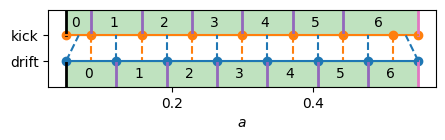

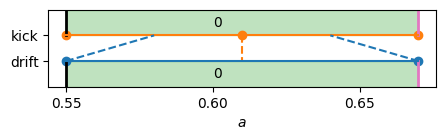

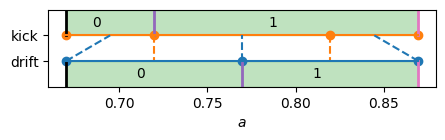

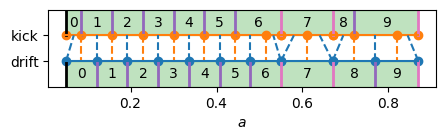

In [6]:
if gravity_on:
    reset_plotting()  # Default style for Simbelmynë
    merged_path = f"{modeldir}merged.h5"
    if not exists(merged_path) or force:
        # Determine the number of steps between consecutive scale factors
        nsteps = [
            round((aa[i + 1] - aa[i]) / (aa[-1] - aa[0]) * total_steps) for i in range(len(aa) - 1)
        ]
        if sum(nsteps) != total_steps:
            nsteps[nsteps.index(max(nsteps))] += total_steps - sum(nsteps)
        indices_steps_cumul = list(np.cumsum(nsteps) - 1)
        np.save(f"{modeldir}indices_steps_cumul.npy", indices_steps_cumul)

        # Generate and save individual time-stepping files for Simbelmynë
        TSs = []
        TS_paths = []
        for i, (ai, af) in enumerate(zip(aa[:-1], aa[1:])):
            snapshots = np.full((nsteps[i]), False)
            snapshots[-1] = True  # Mark the last step as a snapshot
            TS = StandardTimeStepping(ai, af, snapshots, 0)
            TS_path = f"{modeldir}ts{i + 1}.h5"
            TS.write(TS_path)
            TSs.append(read_timestepping(TS_path))
            TS_paths.append(TS_path)

        # Plot individual time-stepping
        for i, TS in enumerate(TSs):
            TS.plot(path=modeldir + "TS" + str(i) + ".png")

        # Merge all time-stepping files into a single file
        merge_nTS(TS_paths, merged_path)
    else:
        indices_steps_cumul = np.load(f"{modeldir}indices_steps_cumul.npy")

    TS_merged = read_timestepping(merged_path)
    TS_merged.plot(path=modeldir + "TS_merged.png")  # Plot the merged time-stepping
    setup_plotting()  # Reset plotting style for this project
else:
    merged_path = None
    indices_steps_cumul = None

In [7]:
if (not exists(modeldir + "theta_gt.npy")) or force:
    from pysbmy.power import get_Pk

    theta_gt = get_Pk(k_s, params_cosmo_obs)
    np.save(modeldir + "theta_gt", theta_gt)
else:
    theta_gt = np.load(modeldir + "theta_gt.npy")

In [8]:
print("Instantiating the HiddenBox...")
HB_selfi = HiddenBox(
    k_s=k_s,
    P_ss_path=P_ss_obj_path,
    Pbins_bnd=Pbins_bnd,
    theta2P=theta2P,
    P=P * Npop,
    size=size,
    L=L,
    G_sim_path=G_sim_path,
    G_ss_path=G_ss_path,
    Np0=Np0,
    Npm0=Npm0,
    fsimdir=wd[:-1],
    noise_std=noise,
    radial_selection=radial_selection,
    selection_params=selection_params,
    observed_density=obs_density,
    linear_bias=lin_bias,
    norm_csts=None,
    survey_mask_path=survey_mask_path,
    local_mask_prefix=id_obs,
    sim_params=sim_params,
    TimeStepDistribution=merged_path,
    TimeSteps=indices_steps_cumul,  
    eff_redshifts=1 / aa[-1] - 1,
    seedphase=seedphase,  # Default, global value for the class instance
    seednoise=seednoise,  # Default, global value for the class instance
    fixnoise=False,
    seednorm=seednorm,
    reset=True,  # Reset the survey mask at instantiation
    save_frequency=5,
    verbosity=0,
)

if not exists(modeldir + "norm_csts.npy") or force:
    from selfisys.normalise_hb import define_normalisation

    HB_selfi.switch_recompute_pool()
    norm_csts = define_normalisation(
        HB_selfi,
        Pbins,
        params_planck,
        Nnorm,
        min_k_norma=MIN_K_NORMALISATION,
        npar=1,
        force=force,
    )
    HB_selfi.switch_recompute_pool()
    np.save(modeldir + "norm_csts.npy", norm_csts)
else:
    print("> Normalisation constants already exist.")
    norm_csts = np.load(modeldir + "norm_csts.npy")
HB_selfi.update(norm_csts=norm_csts)

Instantiating the HiddenBox...
[21:58:53|INFO      ]|(selfisys.utils.plot_utils) Plotting selection functions...
[21:58:53|INFO      ]|(selfisys.utils.plot_utils) Figure saved to /Users/hoellinger/SELFI/demo/1283600502/ref_n01/model/obs_rawmask_n01_wRSDs_select_fct.png
[21:58:54|STATUS    ]|Defining normalisation constants...


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
if not exists(modeldir + f"phi_{id_obs}.npy") or force or force_obs:
    d_obs = -1
    HB_selfi.switch_recompute_pool()
    phi_obs, g_obs = HB_selfi.make_data(
        cosmo=params_cosmo_obs,
        id=baseid_obs,
        seedphase=seedphase_obs,
        seednoise=seednoise_obs,
        d=d_obs,
        force_powerspectrum=force_obs,
        force_parfiles=force_obs,
        force_sim=force_obs,
        force_cosmo=force_obs,
        return_g=True,
        RSDs=RSDs,
        prefix_mocks=id_obs,
    )
    HB_selfi.switch_recompute_pool()
    g_obs = np.array(g_obs)
    np.save(modeldir + f"phi_{id_obs}.npy", phi_obs)
    np.save(modeldir + f"g_{id_obs}.npy", g_obs)
else:
    print("Observed data already exist.")
    phi_obs = np.load(modeldir + f"phi_{id_obs}.npy")
    g_obs = np.load(modeldir + f"g_{id_obs}.npy")

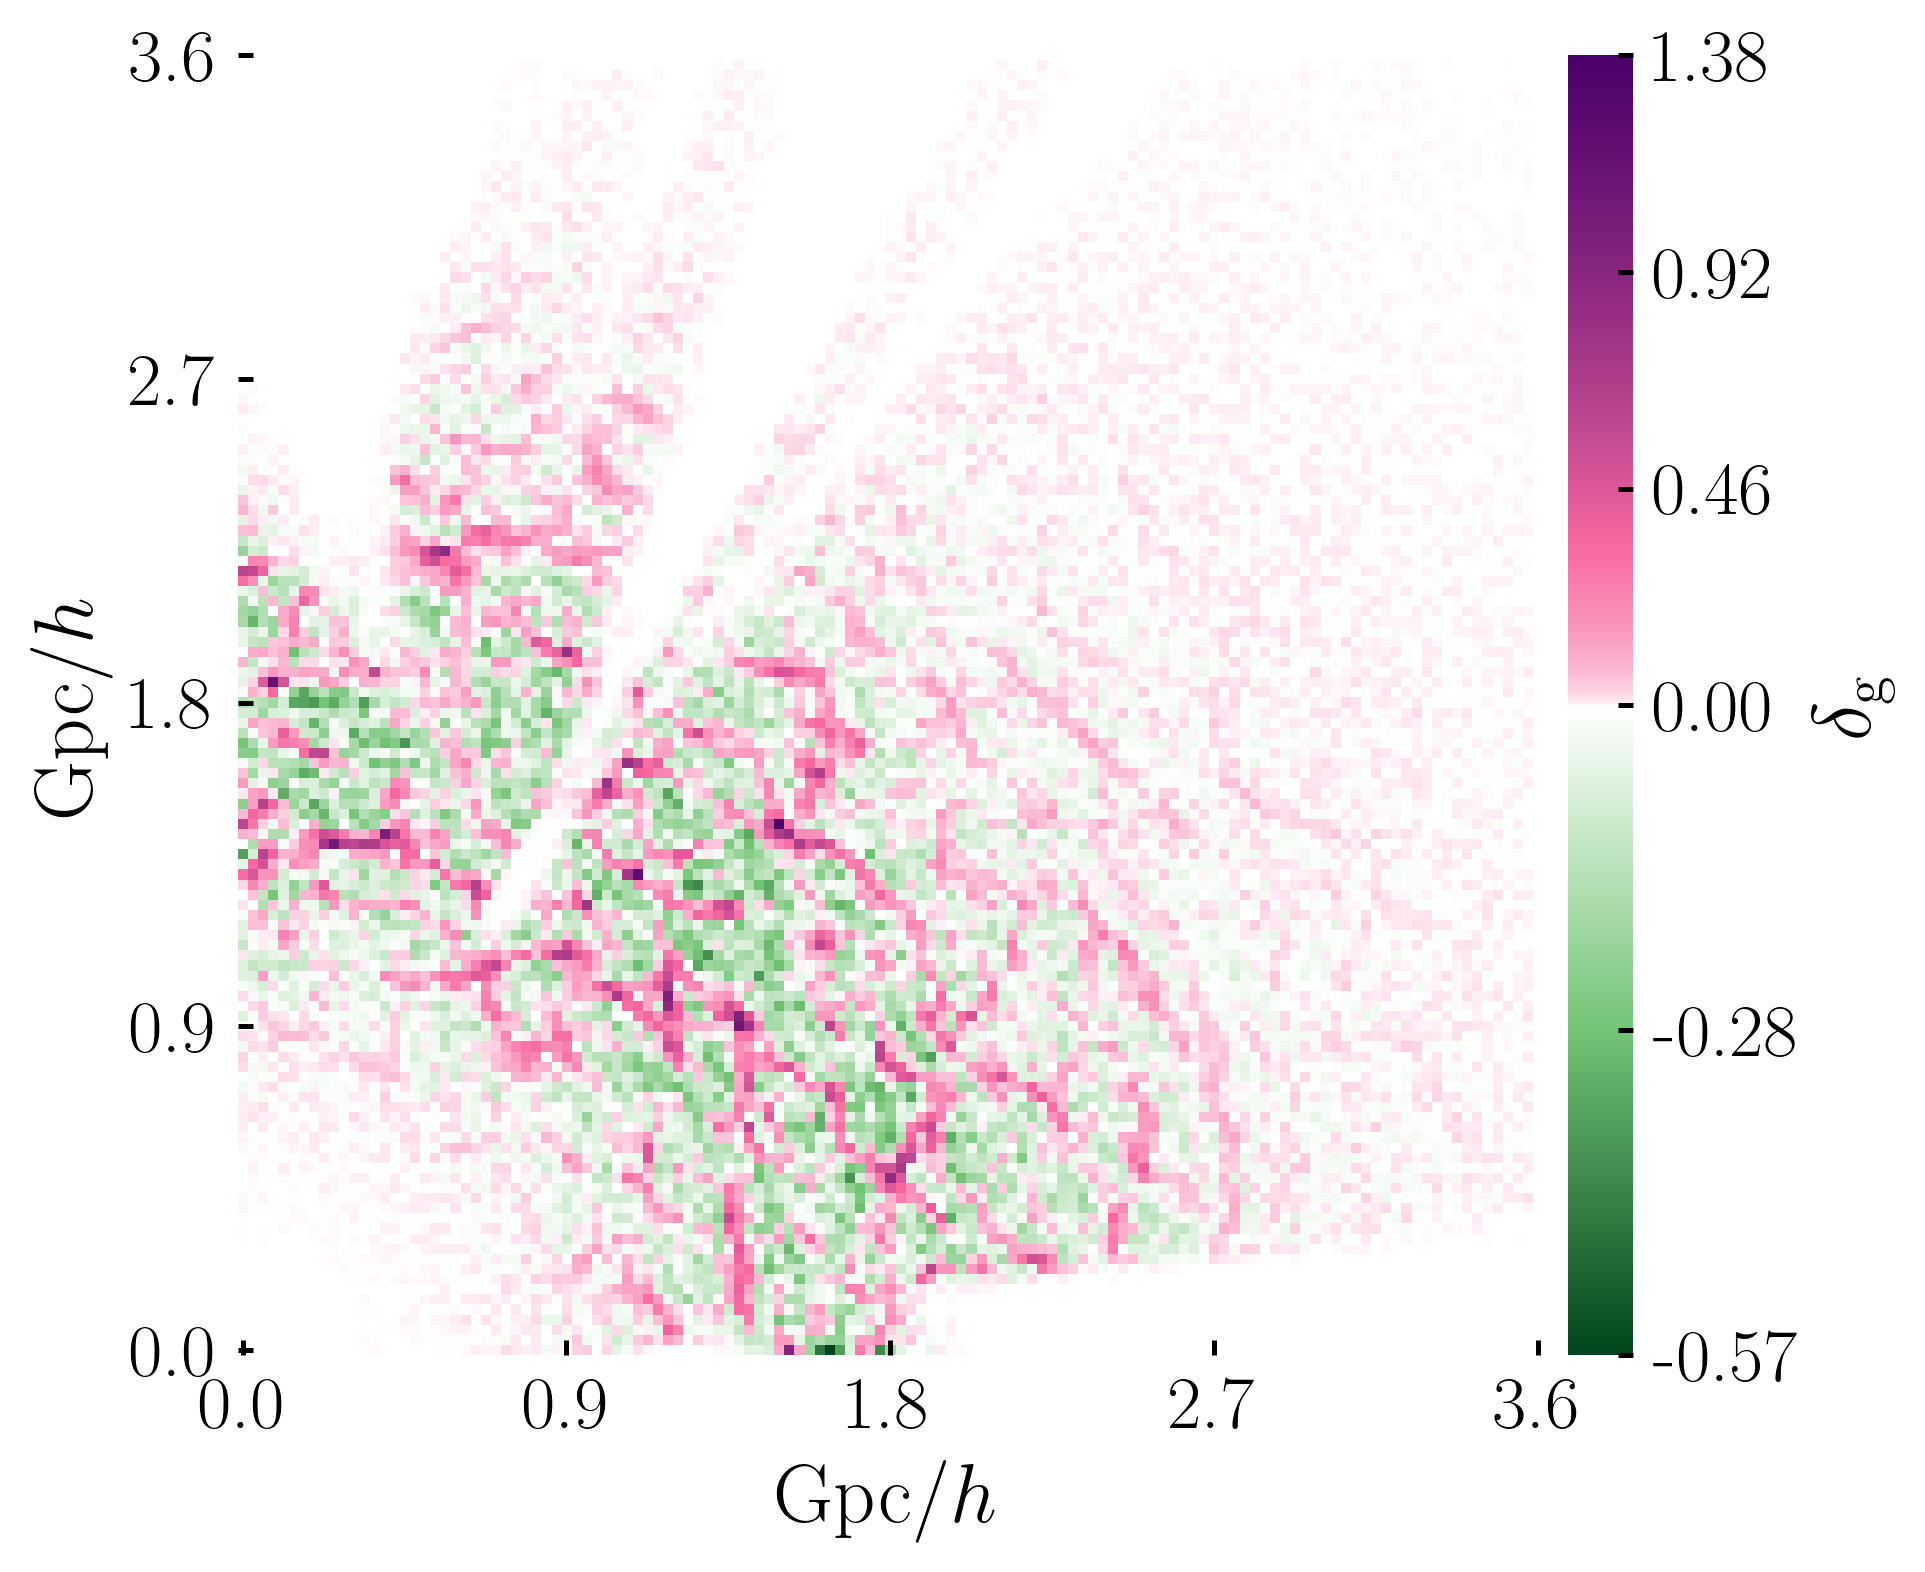

In [10]:
# Extract and display one slice through the observed field for population i
i = 1
g = g_obs[i][:, :, int(size // 12)]

# Save slices through the observed field for all populations
plot_galaxy_field_slice(g, size, L, wd, id_obs)
for i in range(3):
    plot_galaxy_field_slice(
        g_obs[i][:, :, int(size // 12)], size, L, wd, id_obs + f"pop{i+1}", display=False
    )

In [11]:
# Visualise the 3D grid mask
pop_idx = 2
if size <= 128:
    fig = plotly_3d(g_obs[pop_idx], size, colormap="Blues", limits="truncate")
else:
    # Downsample the grid for visualisation
    downsample_factor = size // 128
    downsampled_field = g_obs[
        pop_idx, ::downsample_factor, ::downsample_factor, ::downsample_factor
    ]
    fig = plotly_3d(downsampled_field, L=L, colormap="Blues", limits="truncate")

# fig.show()
# # clear_large_plot(fig)  # Uncomment to clear the Plotly figure to avoid memory issues

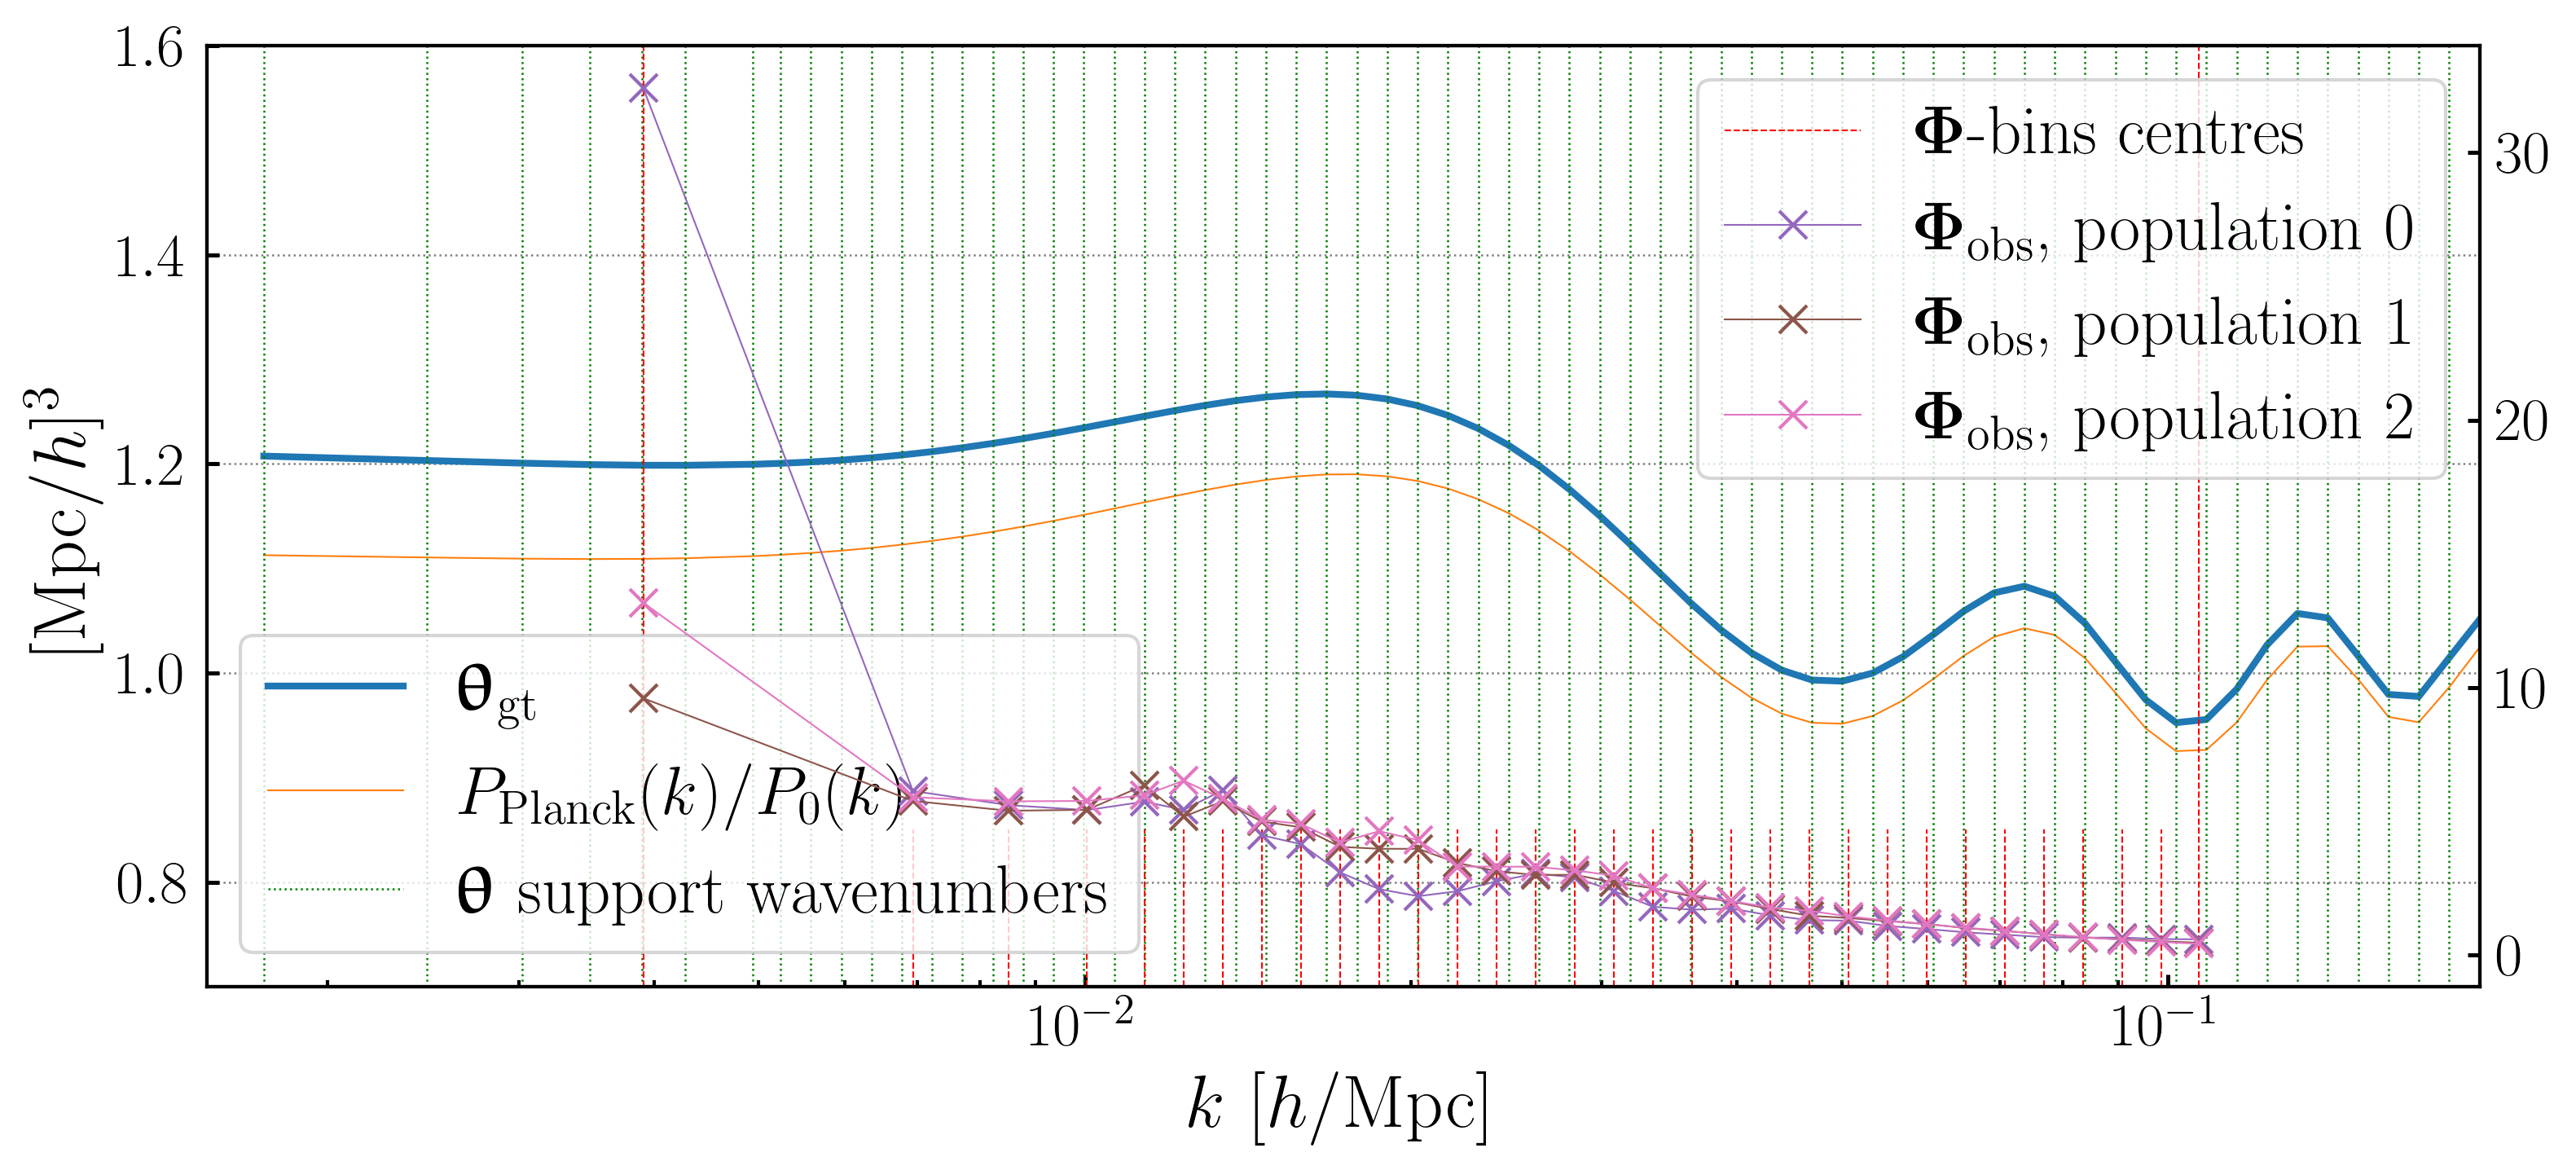

In [12]:
plot_observations(k_s, theta_gt, planck_Pk_EH, P_0, Pbins, phi_obs, Npop,
                  path=wd + f"Figures/observations_{id_obs}.png", force_plot=True)